In [88]:
#NOTE IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd # Dataframe
import seaborn as sns # Boxplot


In [89]:
#NOTE CONSTANTS

AZIMUTH_MIN     = -180 # "under"-rotation
AZIMUTH_MAX     = 540 # with over-rotation
ELEVATION_MIN   = 17 # balcony ground collision at <=14°
ELEVATION_MAX   = 163 # flip-over
AZ_SPEED        = 1.6 # degrees per second, practically tested
EL_SPEED        = 1.3


waypoints = [
    #AZ     EL
    (0,     17), # parking position
    (350,   30),
    (180,   85),
    (0,     85),
    (90,    60),
    (10,    20),
    (270,   80),
    (45,    40),
    (165,   40),
]

In [90]:
#NOTE COORDINATE TRANSFORMATION

def azel_to_cartesian(az_deg: float, el_deg: float) -> np.ndarray:
    az = np.radians(az_deg)
    el = np.radians(el_deg)
    # standard unit spherical coordinates
    x = np.cos(el) * np.cos(az)
    y = np.cos(el) * np.sin(az)
    z = np.sin(el)
    return np.array([x, y, z])




def cartesian_to_azel(vec: np.ndarray) -> Tuple[float, float]:
    x, y, z = vec
    hyp = np.hypot(x, y) # hypotenuse = sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(y, x)) % 360 # full-circle azimuth
    el = np.degrees(np.arctan2(z, hyp))
    return az, el




def azel_to_polar(az_deg: float, el_deg: float) -> Tuple[float, float]:
    if el_deg > 90:
        el_deg = 180 - el_deg # flip over adjusting
    theta = np.radians(az_deg % 360)
    radius = 90 - el_deg # center = el_90
    return theta, radius

In [91]:
#NOTE SLERP

def slerp_path(start_az: float, start_el: float, end_az: float, end_el: float, steps: int = 1000) -> List[Tuple[float, float]]:
    # convert to 3D vectors
    p0 = azel_to_cartesian(start_az, start_el)
    p1 = azel_to_cartesian(end_az, end_el)

    # angle between start/end vector in radians
    # dot product of 2 unit vectors => cos(omega) (since theta will be used for polar)
    omega = np.arccos(np.clip(np.dot(p0, p1), -1.0, 1.0)) # ensure it stays between -1 and 1

    # small angles ~ linear anyway
    if np.isclose(omega, 0):
        return [(start_az, start_el)] * steps

    # otherwise calculate steps along the path
    sin_omega = np.sin(omega)
    path = []

    # formula: point(t) = [sin((1-t)*omega)*p0 + sin(t*omega)*p1]/sin(omega) -> sin() = weights
    # no weights -> cut through circle, like |x| + |y| + |z|
    # interpolate along spherical arc
    for t in np.linspace(0, 1, steps):
        factor0 = np.sin((1-t) * omega) / sin_omega
        factor1 = np.sin(t * omega) / sin_omega
        pt = factor0 * p0 + factor1 * p1
        az, el = cartesian_to_azel(pt) # reverse coordinate after calculation of path
        path.append((az, el))
    return path

In [92]:
#NOTE MOVEMENT TIME CALCULATION

# Helper function
# Gives angular difference in signed 180 range, thus showing direction [-180.0, 180.0]
def wrap180(az_diff):
    return (az_diff + 180.0) % 360.0 - 180.0

def time_from_coords(start, end):
    az1, el1 = start
    az2, el2 = end
    delta_az = abs(wrap180(az2 - az1))
    delta_el = abs(el2 - el1)
    return max(delta_az / AZ_SPEED, delta_el / EL_SPEED)

def movement_time(start: Tuple[float, float], end: Tuple[float, float]) -> float:
    # Extract coordinates
    az_start, el_start = start
    az_end, el_end = end

    # Shortest distances for AZ/EL
    delta_az = min(abs(az_end - az_start), 360 - abs(az_end - az_start))
    delta_el = abs(el_end - el_start)

    time_az = delta_az / AZ_SPEED
    time_el = delta_el / EL_SPEED

    return max(time_az, time_el) # Simultaneous AZ/EL movement


'''def slerp_path_time_old(path: List[Tuple[float, float]]) -> float:
    total_time = 0.0
    for i in range(1, len(path)):
        total_time += movement_time(path[i-1], path[i])
    return total_time

def slerp_path_time_new(path):
    total_time = 0.0
    prev_az, prev_el = path[0]
    for az, el in path[1:]:
        delta_az = abs(wrap180(az - prev_az))   # shortest signed difference
        delta_el = abs(el - prev_el)
        total_time += max(delta_az / AZ_SPEED, delta_el / EL_SPEED)
        prev_az, prev_el = az, el
    return total_time

def slerp_path_time_fixed(path):
    total_time = 0.0
    for i in range(1, len(path)):
        total_time += time_from_coords(path[i-1], path[i])
    return total_time'''

def path_time_continuous(path):
    total_az = 0.0
    total_el = 0.0

    for i in range(1, len(path)):
        az1, el1 = path[i-1]
        az2, el2 = path[i]
        total_az += abs(wrap180(az2 - az1))
        total_el += abs(el2 - el1)

    # Continuous movement assumption:
    # The path duration is determined by whichever axis takes longer in total
    time_az = total_az / AZ_SPEED
    time_el = total_el / EL_SPEED
    return max(time_az, time_el)

def slerp_direct_time(start, end):
    p0 = azel_to_cartesian(*start)
    p1 = azel_to_cartesian(*end)
    omega = np.arccos(np.clip(np.dot(p0, p1), -1.0, 1.0))
    arc_deg = np.degrees(omega)

    time_az = arc_deg / AZ_SPEED
    time_el = arc_deg / EL_SPEED

    return max(time_az, time_el)

slerp_path_time = path_time_continuous

In [93]:
#NOTE HELPER functions

# Returns shortest rotation, positive -> clockwise, negative -> widdershins
def delta_shortest(az1, az2):
    return wrap180(az2 - az1)




# Calculates runtime for slewing telescope
def time_simult_upgraded(az_abs_diff: float, el_abs_diff: float) -> float:
    t_az = az_abs_diff / AZ_SPEED
    t_el = el_abs_diff / EL_SPEED
    return max(t_az, t_el)




# Constructs straight path for plotting
def straight_path(start: Tuple[float, float], az_diff: float, el_diff: float, steps: int = 500) -> Tuple[float, float]:
    az1, el1 = start
    t = np.linspace(0.0, 1.0, steps)
    az = az1 + az_diff * t
    el = el1 + el_diff * t
    return list(zip(az, el))




# Neither flip-over nor over/underrotate
def normal_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = delta_shortest(az1, az2)
    az_diff = az2 - az1
    el_diff = el2 - el1
    return {
        "name": "no_flip_no_overr",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": straight_path(start, az_diff, el_diff, steps)
    }




def overrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = (az2 - az1) % 360.0
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    # Put coordinates back in 0-360
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "overrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": path
    }




def underrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = (az2 - az1) % 360.0 - 360.0
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "underrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": path
    }




'''def flip_over_old(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end

    mid_el = 90.0
    mid_az = (az1 + 180.0) % 360.0

    el_up = np.linspace(el1, mid_el, steps // 2)
    az_up = np.full_like(el_up, az1)
    path_up = list(zip(az_up, el_up))

    el_down = np.linspace(mid_el, el2, steps // 2)
    az_down = np.linspace(mid_az, az2, steps // 2)
    path_down = list(zip(az_down, el_down))

    path = path_up + path_down

    az_diff = abs(mid_az - az2)
    el_diff = (mid_el - el1) + (mid_el - el2)

    return {
        "name": "flip-over",
        "diffs": (az_diff, el_diff),
        "time": slerp_path_time(path),
        "path": [(az % 360.0, el) for az, el in path]
    }'''


def flip_over(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end

    mid_el = 90.0
    mid_az = (az1 + 180.0) % 360.0

    # Segment 1: pure elevation up to zenith
    time_up = abs(mid_el - el1) / EL_SPEED
    path_up = straight_path(start, 0.0, mid_el - el1, steps // 2)

    # Segment 2: simultaneous az/el down from zenith to target
    time_down = time_from_coords((mid_az, mid_el), (az2, el2))
    path_down = straight_path((mid_az, mid_el), wrap180(az2 - mid_az), el2 - mid_el, steps // 2)

    total_time = time_up + time_down
    full_path = path_up + path_down
    return {
        "name": "flip-over",
        "diffs": (abs(wrap180(mid_az - az2)), abs(mid_el - el1) + abs(mid_el - el2)),
        "time": total_time,
        "path": [(az % 360.0, el) for az, el in full_path]
    }


In [94]:
#NOTE SIMULTANEOUS PATH WITHOUT OVER/UNDERROTATION OR FLIP-OVER

def simultaneous_az_el_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> List[Tuple[float, float]]:
    az1, el1 = start
    az2, el2 = end

    az_vals = np.linspace(az1, az2, steps)
    el_vals = np.linspace(el1, el2, steps)

    az_vals = np.mod(az_vals, 360.0)

    return list(zip(az_vals, el_vals))

def azel_classic_long_path(start, end, steps=500):
    az1, el1 = start
    az2, el2 = end

    az_diff = (az2 - az1) % 360.0

    az_vals = np.linspace(az1, az1 + az_diff, steps)
    el_vals = np.linspace(el1, el2, steps)
    az_vals = np.mod(az_vals, 360.0)

    return list(zip(az_vals, el_vals))

In [95]:
# NOTE UPGRADED LOGIC, SIMULT AZEL WITH OVER/UNDERROTATION AND FLIP-OVER

def choose_path_logic(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    az1, el1 = start
    az2, el2 = end

    # Determine path baseline values
    az_diff_signed = delta_shortest(az1, az2)

    # Decide if flip-over is useful
    near_zenith = (el1 >= el_flip_thresh) or (el2 >= el_flip_thresh)
    big_az = abs(az_diff_signed) >= az_flip_thresh


    if near_zenith and big_az:
        return flip_over(start, end, steps)

    if (az1 + az_diff_signed > 360.0) and (az1 + az_diff_signed <= 540.0):
        path = overrotate(start, end)["path"]
        time = time_from_coords(start, end)
        return {"name": "overrotate", "diffs": (az_diff_signed, el2 - el1), "time": time, "path": path}

    if (az1 + az_diff_signed < 0.0) and (az1 + az_diff_signed >= -180.0):
        path = underrotate(start, end)["path"]
        time = time_from_coords(start, end)
        return {"name": "underrotate", "diffs": (az_diff_signed, el2 - el1), "time": time, "path": path}


    # Normal (constrained by limits) movement
    path = normal_path(start, end, steps)["path"]
    time = time_from_coords(start, end)
    return {"name": "no_flip_no_overr", "diffs": (az_diff_signed, el2 - el1), "time": time, "path": path}





# Returns path only
def simult_azel_path_smart(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    plan = choose_path_logic(start, end, steps, az_flip_thresh, el_flip_thresh)
    return plan["path"]




# Runs code
def compare_method(wps: List[Tuple[float, float]], steps: int = 500) -> pd.DataFrame:
    rows = []
    for i in range(len(wps) - 1):
        start, end = wps[i], wps[i+1]
        
        path_basic = simultaneous_az_el_path(start, end, steps=steps)
        time_basic = slerp_path_time(path_basic)
        rows.append({"From": start, "To": end, "Method": "AZ+EL Simult.", "Time (s)": time_basic})

        path_upgraded = simult_azel_path_smart(start, end, steps=steps)
        time_upgraded = slerp_path_time(path_upgraded)
        rows.append({"From": start, "To": end, "Method": "AZ+EL Upgraded", "Time (s)": time_upgraded})

        
        path_slerp = slerp_path(*start, *end, steps=500)
        time_slerp = slerp_direct_time(start, end)
        rows.append({"From": start, "To": end, "Method": "SLERP", "Time (s)": time_slerp})

    df = pd.DataFrame(rows)
    # Rounding
    df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
    df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

    return df

In [96]:
#NOTE MAIN, COLLECTS ALL PATHS

def calc_paths(waypoints=waypoints):
    all_paths = []
    for i in range(len(waypoints) -1): 
        start = waypoints[i]
        end = waypoints[i + 1]

        # SLERP path and time
        path_slerp = slerp_path(*start, *end, steps=500)
        time_slerp = slerp_direct_time(start, end)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "SLERP",
            "Time (s)": round(time_slerp, 2),
            "Path": path_slerp
            })

        # Simultaneous AZ+EL path
        path_simult = simultaneous_az_el_path(start, end, steps=500)
        time_simult = slerp_path_time(path_simult)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "AZ+EL Simult",
            "Time (s)": round(time_simult, 2),
            "Path": path_simult
        })

        # Upgraded
        plan = choose_path_logic(start, end, steps=500)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "AZ+EL Upgraded",
            "Time (s)": round(plan["time"], 2),
            "Path": plan["path"]
        })
    return all_paths

all_paths = calc_paths()

In [97]:
#NOTE DATAFRAME CONVERSION

def dataframe_conv(all_paths = all_paths):
    df = pd.DataFrame(all_paths)
    df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
    df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

    #print(df[["From", "To", "Path Type", "Time (s)"]].to_string(index=False))

    # Statistics
    # Group by coordinate pair -> select time column -> find index (row number) with minimum time -> loc selects actual rows after they are found
    fastest_per_segment = df.loc[df.groupby(["From", "To"])["Time (s)"].idxmin()]
    print(f"\nFastest per segment:\n{fastest_per_segment[["From", "To", "Path Type", "Time (s)"]]}")

    # Best
    win_counts = fastest_per_segment["Path Type"].value_counts()
    print(f"\nWin counts by {win_counts}")

    # Average Time per path type
    avg_times = df.groupby("Path Type")["Time (s)"].mean().sort_values()
    print(f"\nAverage Times:\n{avg_times}")
    return df

df = dataframe_conv()


Fastest per segment:
         From         To       Path Type  Time (s)
2     (0, 17)  (350, 30)  AZ+EL Upgraded     10.00
9     (0, 85)   (90, 60)           SLERP     23.37
15   (10, 20)  (270, 80)           SLERP     55.41
21   (45, 40)  (165, 40)           SLERP     63.94
13   (90, 60)   (10, 20)    AZ+EL Simult     50.00
6   (180, 85)    (0, 85)           SLERP      7.69
18  (270, 80)   (45, 40)           SLERP     44.14
3   (350, 30)  (180, 85)           SLERP     49.94

Win counts by Path Type
SLERP             6
AZ+EL Upgraded    1
AZ+EL Simult      1
Name: count, dtype: int64

Average Times:
Path Type
SLERP              38.60875
AZ+EL Upgraded     49.77750
AZ+EL Simult      115.23375
Name: Time (s), dtype: float64


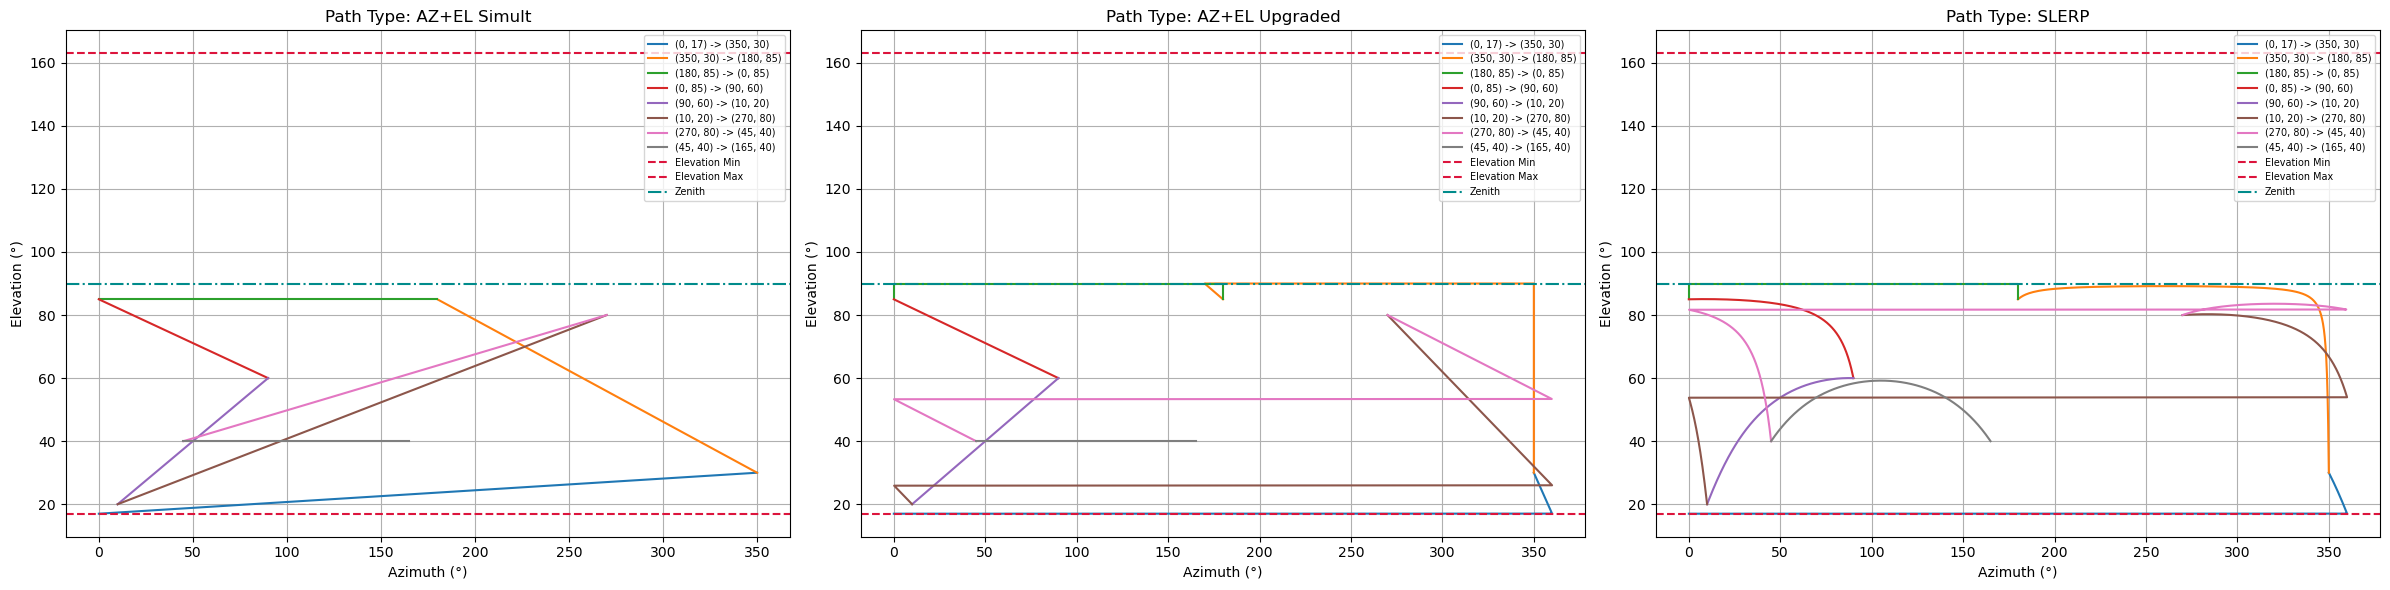

In [98]:
#NOTE 2D-AZEL-PROJECTED PLOT

path_types = sorted(set(entry["Path Type"] for entry in all_paths))

rows = 1
cols = int(np.ceil(len(path_types)))
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), subplot_kw={"polar": False})
axes = axes.flat


for ax, path_type in zip(axes, path_types):
    for i, entry in enumerate(all_paths):
        if entry["Path Type"] == path_type:
            path = entry["Path"]
            az_list, el_list = zip(*path)
            az_list = [a % 360.0 for a in az_list]
            ax.plot(az_list, el_list, label=f"{entry['From']} -> {entry['To']}")

    ax.set_title(f"Path Type: {path_type}")
    ax.set_xlabel("Azimuth (°)")
    ax.set_ylabel("Elevation (°)")
    ax.axhline(y=ELEVATION_MIN, color="crimson", linestyle="--", label="Elevation Min")
    ax.axhline(y=ELEVATION_MAX, color="crimson", linestyle="--", label="Elevation Max")
    ax.axhline(y=90, color="darkcyan", linestyle="-.", label="Zenith")
    ax.grid(True)
    ax.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

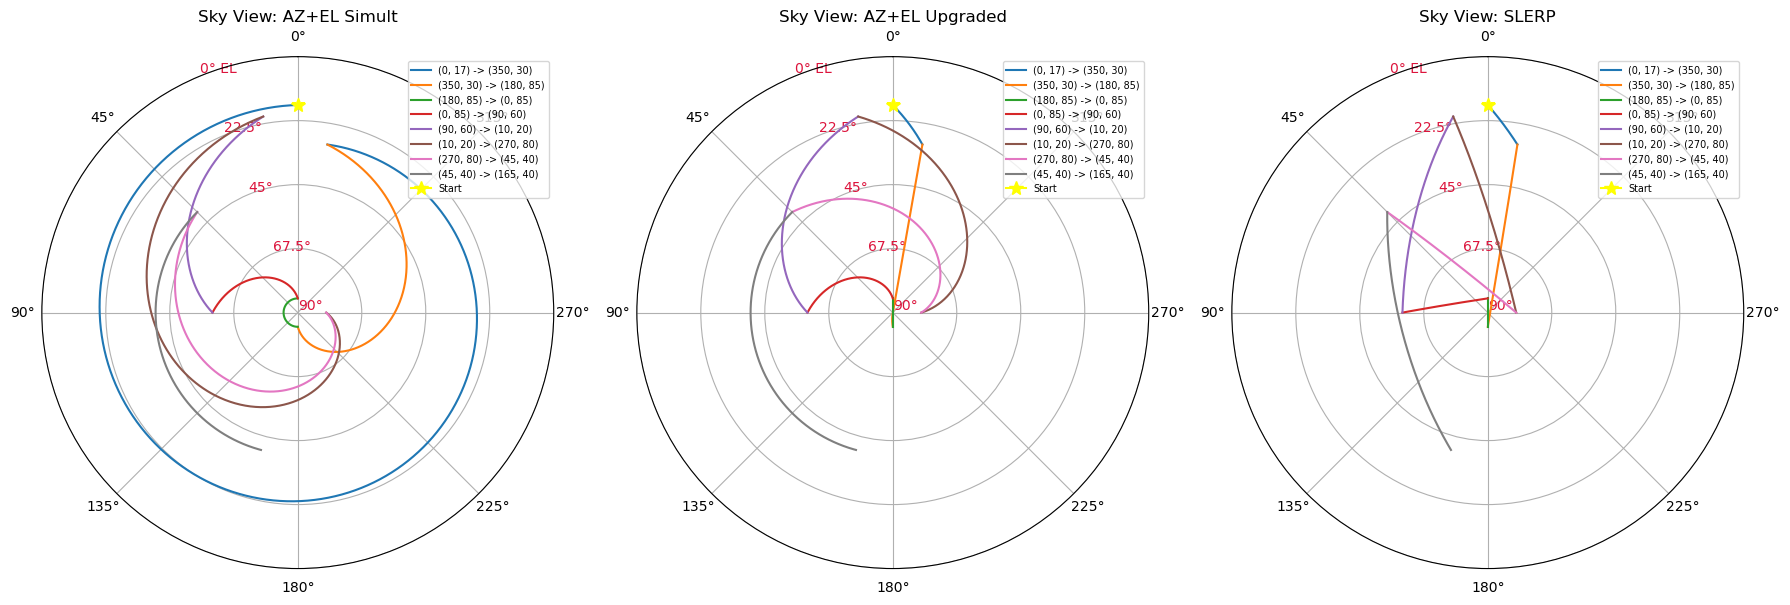

In [99]:
#NOTE POLAR-PROJECTED PLOTS

def polar_proj(all_paths=all_paths, legend=True):
    rows = 1
    cols = int(np.ceil(len(path_types)))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), subplot_kw={"polar": True})
    axes = axes.flat

    for ax, path_type in zip(axes, path_types):
        for i, entry in enumerate(all_paths):
            if entry["Path Type"] == path_type:
                path = entry["Path"]
                theta_and_r = [azel_to_polar(az, el) for az, el in path]
                theta, r = zip(*theta_and_r)
                from_coord = tuple(round(x, 2) for x in entry["From"])
                to_coord = tuple(round(y, 2) for y in entry["To"])
                ax.plot(theta, r, label=f"{from_coord} -> {to_coord}")

        # Starting point
        theta0, r0 = azel_to_polar(*waypoints[0])
        ax.plot([theta0], [r0], marker="*", markersize=10, color="yellow", label="Start")

        # Subplot formatting
        ax.set_title(f"Sky View: {path_type}")
        ax.set_ylim(0, 75)
        ax.set_yticks([0, 22.5, 45, 67.5, 90])
        ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0° EL"])
        for label in ax.get_yticklabels():
            label.set_color("crimson")
        ax.set_theta_zero_location("N")
        ax.grid(True)
        if legend:
            ax.legend(loc="upper right", fontsize="x-small")

    plt.tight_layout()
    plt.show()
    return

polar_proj()

In [100]:
# Blockierte Bereiche durch Bäume oder Hindernisse, thx an Eva
blocked_areas =[{'azimuth_range': (0, 12), 'elevation_range': (0, 50)},
                {'azimuth_range': (12, 24), 'elevation_range': (0, 46)},
                {'azimuth_range': (24, 36), 'elevation_range': (0, 44)},
                {'azimuth_range': (36, 48), 'elevation_range': (0, 41)},
                {'azimuth_range': (48, 60), 'elevation_range': (0, 41)},
                {'azimuth_range': (60, 72), 'elevation_range': (0, 43)},
                {'azimuth_range': (72, 84), 'elevation_range': (0, 44.5)},
                {'azimuth_range': (84, 96), 'elevation_range': (0, 45)},
                {'azimuth_range': (96, 108), 'elevation_range': (0, 45.6)},
                {'azimuth_range': (108, 120), 'elevation_range': (0, 39.9)},
                {'azimuth_range': (120, 132), 'elevation_range': (0, 27)},
                {'azimuth_range': (132, 144), 'elevation_range': (0, 19.66)},
                {'azimuth_range': (144, 156), 'elevation_range': (0, 18.5)},
                {'azimuth_range': (156, 168), 'elevation_range': (0, 15)},
                {'azimuth_range': (168, 180), 'elevation_range': (0, 9.5)},
                {'azimuth_range': (180, 192), 'elevation_range': (0, 11)},
                {'azimuth_range': (192, 204), 'elevation_range': (0, 16)},
                {'azimuth_range': (204, 216), 'elevation_range': (0, 21.6)},
                {'azimuth_range': (216, 228), 'elevation_range': (0, 23.2)},
                {'azimuth_range': (228, 240), 'elevation_range': (0, 25.7)},
                {'azimuth_range': (240, 252), 'elevation_range': (0, 27)},
                {'azimuth_range': (252, 264), 'elevation_range': (0, 26)},
                {'azimuth_range': (264, 276), 'elevation_range': (0, 30.4)},
                {'azimuth_range': (276, 288), 'elevation_range': (0, 31)},
                {'azimuth_range': (288, 300), 'elevation_range': (0, 30)},
                {'azimuth_range': (300, 312), 'elevation_range': (0, 36)},
                {'azimuth_range': (312, 324), 'elevation_range': (0, 42)},
                {'azimuth_range': (324, 336), 'elevation_range': (0, 45)},
                {'azimuth_range': (336, 348), 'elevation_range': (0, 46)},
                {'azimuth_range': (348, 360), 'elevation_range': (0, 50)}]

In [101]:
#NOTE WAYPOINT GENERATOR + CALCULATING TIME FOR EACH WAYPOINT

def is_blocked(az: float, el: float, blocked_areas: list = blocked_areas) -> bool:
    for sector in blocked_areas:
        az_min, az_max = sector['azimuth_range']
        el_min, el_max = sector['elevation_range']

        in_az_range = az_min <= az < az_max
        if in_az_range and (el_min <= el <= el_max):
            return True # in blocked area

    return False # not blocked

def random_waypoints(n: int = 10) -> List[Tuple[float, float]]:
    wpts = []

    while len(wpts) < n:
        az = np.random.uniform(0, 360)
        el = np.random.uniform(ELEVATION_MIN, 90.0)

        if not is_blocked(az, el):
            wpts.append((az, el))

    return wpts




def benchmark_segment(wps: List[Tuple[float, float]]):
    method_times = {
        "SLERP": [],
        "AZ+EL Simult": []
        }

    # Waypoint pairs for moving
    for i in range(len(wps) - 1):
        s, e = wps[i], wps[i + 1]

        method_times["SLERP"].append(slerp_path_time(slerp_path(*s, *e, steps=100)))

        sim_path = simultaneous_az_el_path(s, e, steps=100)
        method_times["AZ+EL Simult"].append(slerp_path_time(sim_path))

    return method_times

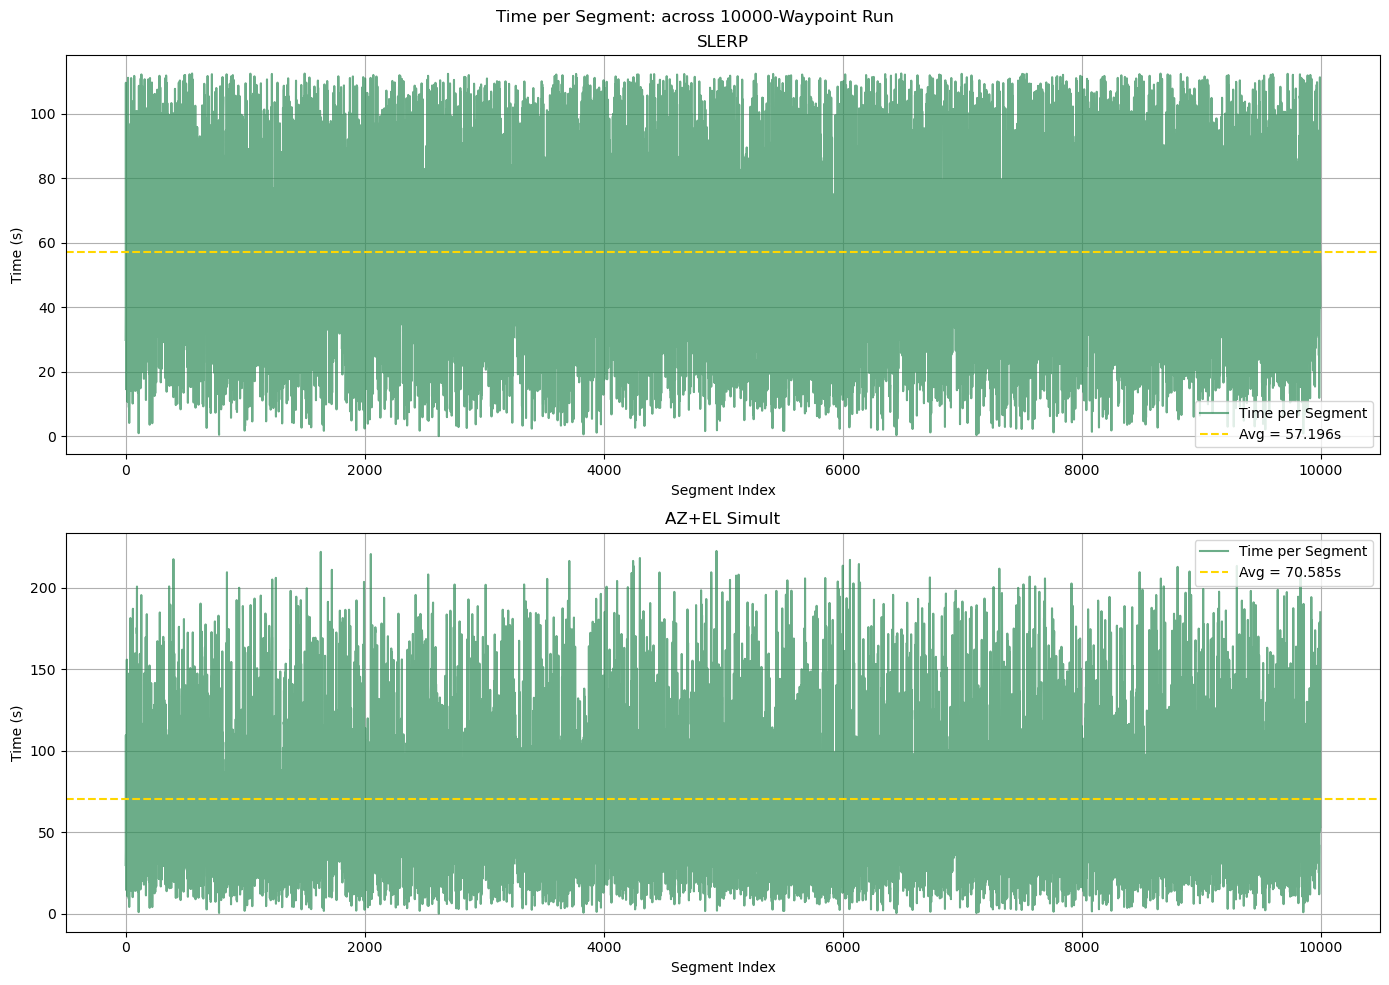

In [102]:
#NOTE PLOT LONG TERM BEHAVIOUR

def plot_time_per_segment(method_times: dict, n: int=10):
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))
    axs = axs.flatten()

    for i, (method, times) in enumerate(method_times.items()):
        ax = axs[i]
        x = np.arange(len(times))
        y = np.array(times)

        ax.plot(x, y, label="Time per Segment", alpha=0.7, color="seagreen")
        ax.axhline(np.mean(y), color="gold", linestyle="--", label=f"Avg = {np.mean(y):.3f}s")

        ax.set_title(method)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Segment Index")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Time per Segment: across {n}-Waypoint Run")
    plt.tight_layout()
    plt.show()

N = 10000 # ADJUST HERE
wps = random_waypoints(N)
segment_times = benchmark_segment(wps)
plot_time_per_segment(segment_times, N)

In [103]:
#NOTE AVG DIFFS BETWEEN AXES

def average_delta(wps):
    total_az = 0
    total_el = 0
    for i in range(len(wps) - 1):
        az1, el1 = wps[i]
        az2, el2 = wps[i + 1]
        delta_az = min(abs(az2 - az1), 360 - abs(az2 - az1))
        delta_el = abs(el2 - el1)
        total_az += delta_az
        total_el += delta_el
    return total_az / (len(wps) - 1), total_el / (len(wps) - 1)

print("fixed  avg deltas", average_delta(waypoints))
print("random avg deltas", average_delta(wps))

fixed  avg deltas (110.625, 29.125)
random avg deltas (88.78461918155872, 20.88817131368339)


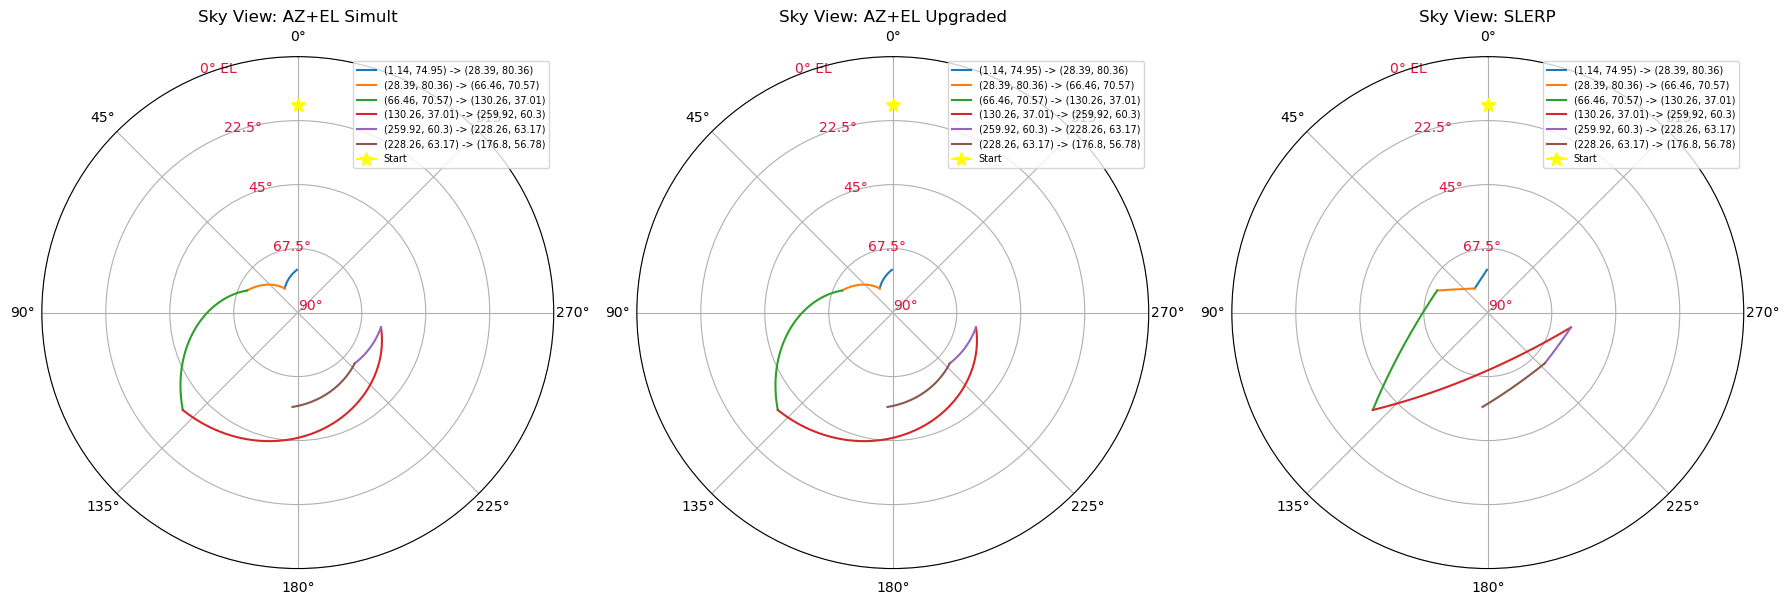

In [104]:
#NOTE PATH SHOWCASE OF RANDOM WPTS

wpts = random_waypoints(n=7)

all_paths2 = calc_paths(waypoints=wpts)

polar_proj(all_paths=all_paths2)


Fastest per segment:
               From             To     Path Type  Time (s)
1608    (0.6, 56.2)  (208.3, 37.6)         SLERP     64.05
777     (0.8, 71.5)  (216.1, 50.5)         SLERP     42.68
2823    (1.3, 80.2)  (229.6, 69.9)         SLERP     21.22
1521    (1.5, 77.6)  (117.7, 52.5)         SLERP     33.94
1086    (4.3, 51.8)   (78.8, 81.4)         SLERP     28.22
...             ...            ...           ...       ...
2865  (357.0, 69.9)  (209.8, 26.1)         SLERP     62.42
1390  (357.0, 79.8)  (331.6, 47.4)  AZ+EL Simult     24.92
96    (359.0, 72.7)   (69.9, 61.6)         SLERP     21.23
447   (359.1, 71.3)  (220.7, 71.7)         SLERP     26.52
465   (359.8, 82.2)  (253.1, 61.2)         SLERP     24.51

[999 rows x 4 columns]

Win counts by Path Type
SLERP             801
AZ+EL Simult      196
AZ+EL Upgraded      2
Name: count, dtype: int64

Average Times:
Path Type
SLERP             31.441051
AZ+EL Upgraded    50.024995
AZ+EL Simult      70.023383
Name: Time (s), dty

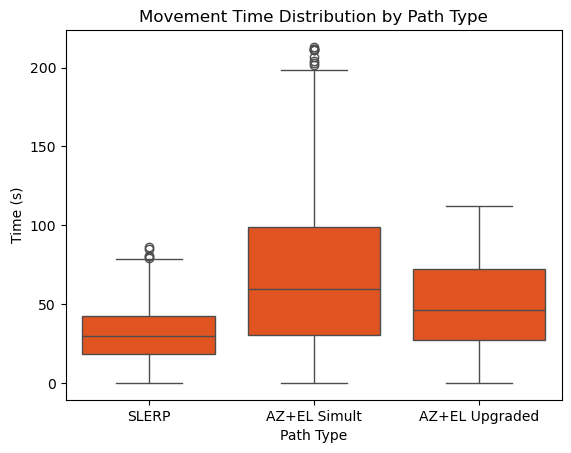

In [105]:
wpts = random_waypoints(n=1000)

all_paths3 = calc_paths(waypoints=wpts)

df3 = dataframe_conv(all_paths=all_paths3)

sns.boxplot(data=df3, x="Path Type", y="Time (s)", color="orangered")
plt.title("Movement Time Distribution by Path Type")
plt.show()


Fastest per segment (sample):
             From             To          Method   Time (s)       Source
1         (0, 17)      (350, 30)  AZ+EL Upgraded  10.000000      Determ.
11        (0, 85)       (90, 60)           SLERP  23.365774      Determ.
1928  (0.2, 85.5)  (190.2, 68.5)           SLERP  20.020365  Random 1000
2723  (0.7, 74.4)   (62.4, 80.4)           SLERP  10.623395  Random 1000
2690  (1.4, 52.0)  (144.4, 50.9)           SLERP  55.701548  Random 1000
2807  (1.7, 87.3)  (155.0, 78.1)           SLERP  11.012859  Random 1000
485   (3.2, 66.3)  (316.2, 54.4)           SLERP  19.417415  Random 1000
1715  (3.6, 78.2)   (63.8, 61.7)           SLERP  18.810997  Random 1000
2972  (4.8, 68.4)  (308.5, 84.6)           SLERP  14.669209  Random 1000
2063  (6.0, 50.2)   (39.1, 46.3)           SLERP  17.082651  Random 1000

Win counts by method:
        Source          Method  Wins
0      Determ.   AZ+EL Simult.     1
1      Determ.  AZ+EL Upgraded     1
2      Determ.           SLERP  

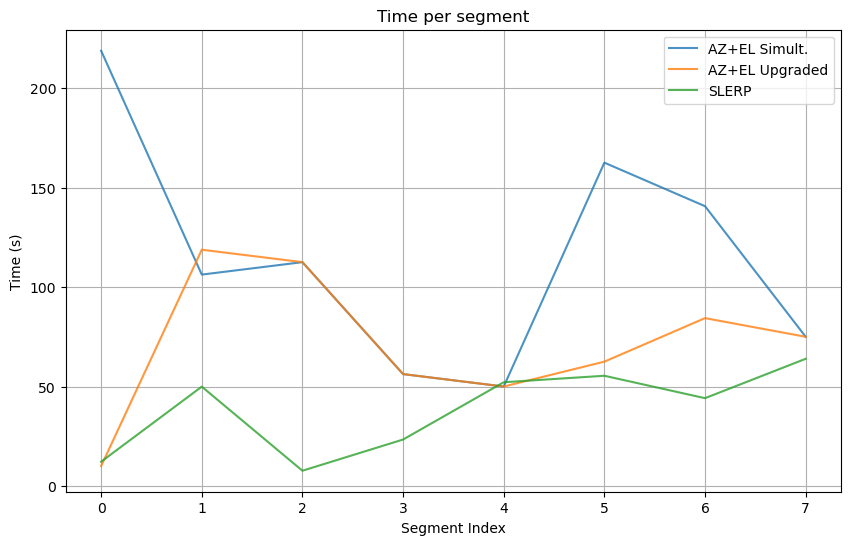

In [106]:
#NOTE PLOT and Statistics

df_predet = compare_method(waypoints, steps=500)

N = 1000
wps = random_waypoints(N)
df_rand = compare_method(wps, steps=500)

df_all = pd.concat([df_predet.assign(Source="Determ."),
                    df_rand.assign(Source=f"Random {N}")],
                    ignore_index=True)




fastest = df_all.loc[df_all.groupby(["From", "To", "Source"])["Time (s)"].idxmin()]
win_counts = fastest.groupby(["Source", "Method"]).size().reset_index(name="Wins")
avg_times =df_all.groupby(["Source", "Method"])["Time (s)"].mean().reset_index()

print("\nFastest per segment (sample):")
print(fastest.head(10))

print("\nWin counts by method:")
print(win_counts)

print("\nAverage time by method:")
print(avg_times)




# Line plot to show difference between basic and upgraded logic
plt.figure(figsize=(10, 6))
for method in df_predet["Method"].unique():
    y = df_predet[df_predet["Method"] == method]["Time (s)"].to_numpy()
    x = np.arange(len(y))
    plt.plot(x, y, label=method, alpha=0.8)
plt.title("Time per segment")
plt.xlabel("Segment Index")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.show()

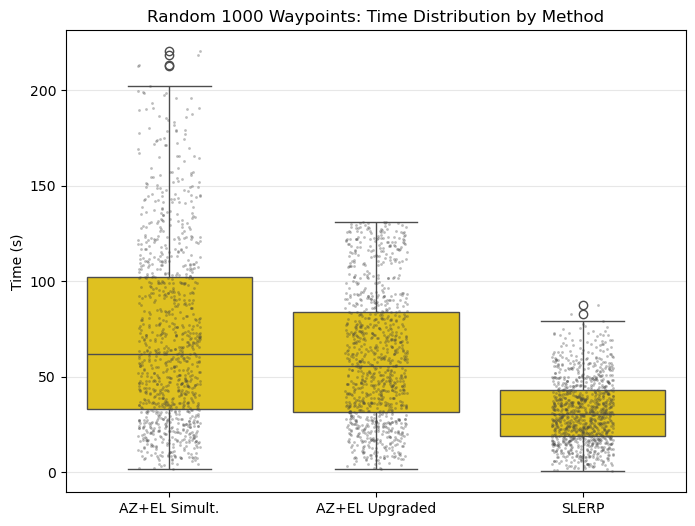

In [107]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_rand, x="Method", y="Time (s)", color="gold")
sns.stripplot(data=df_rand, x="Method", y="Time (s)", alpha=0.35, jitter=0.15, size=2, color=".25")
ax.set_title(f"Random {N} Waypoints: Time Distribution by Method")
ax.set_xlabel("")
ax.set_ylabel("Time (s)")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

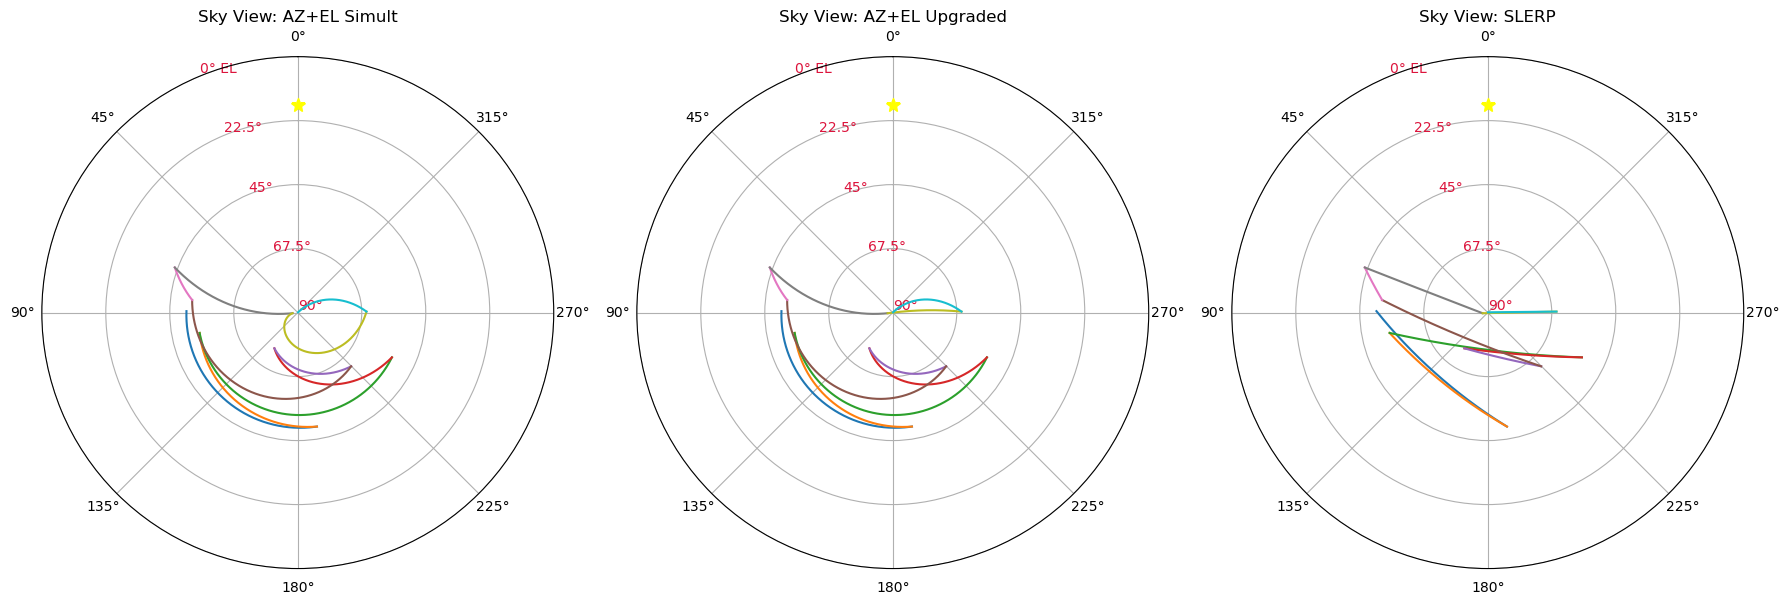

In [108]:
wpts = random_waypoints(n=11)
all_paths4 = calc_paths(waypoints=wpts)
polar_proj(all_paths=all_paths4, legend=False)

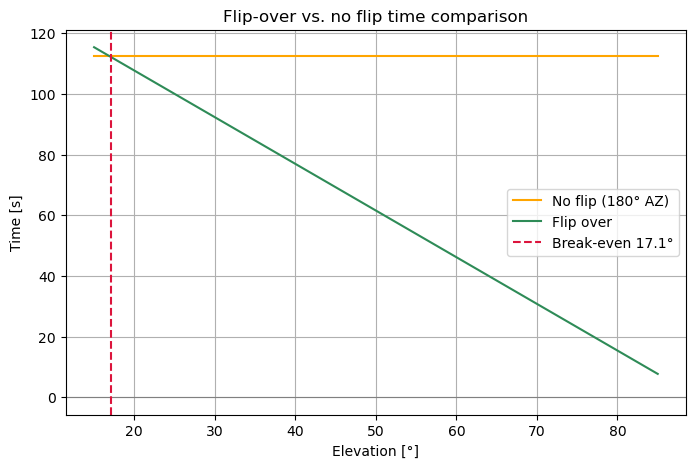

In [109]:
els = np.linspace(15, 85, 200)

# No flip
time_no_flip = (180 / AZ_SPEED)

# Flip over
time_flip = 2* ((90 - els) / EL_SPEED)

plt.figure(figsize=(8,5))
plt.plot(els, time_no_flip*np.ones_like(els), label="No flip (180° AZ)", color="orange")
plt.plot(els, time_flip, label="Flip over", color="seagreen")
plt.axhline(0, color="gray", lw=0.8)
plt.xlabel("Elevation [°]")
plt.ylabel("Time [s]")
plt.title("Flip-over vs. no flip time comparison")
plt.grid(True)
plt.legend()

# Break-even
idx = np.where(time_flip < time_no_flip)[0]
if len(idx) > 0:
    el_break = els[idx[0]]
    plt.axvline(el_break, color="crimson", linestyle="--", label=f"Break-even {el_break:.1f}°")
    plt.legend()

plt.show()

Flip-over rate:     9.722 %
Overrotation rate:  7.562 %
Underrotation rate: 7.502 %



Method counts:

Method
flip-over            486
no_flip_no_overr    3760
overrotate           378
underrotate          375
Name: count, dtype: int64



Dominating axis counts:

DominatingAxis
AZ    4330
EL     669
Name: count, dtype: int64


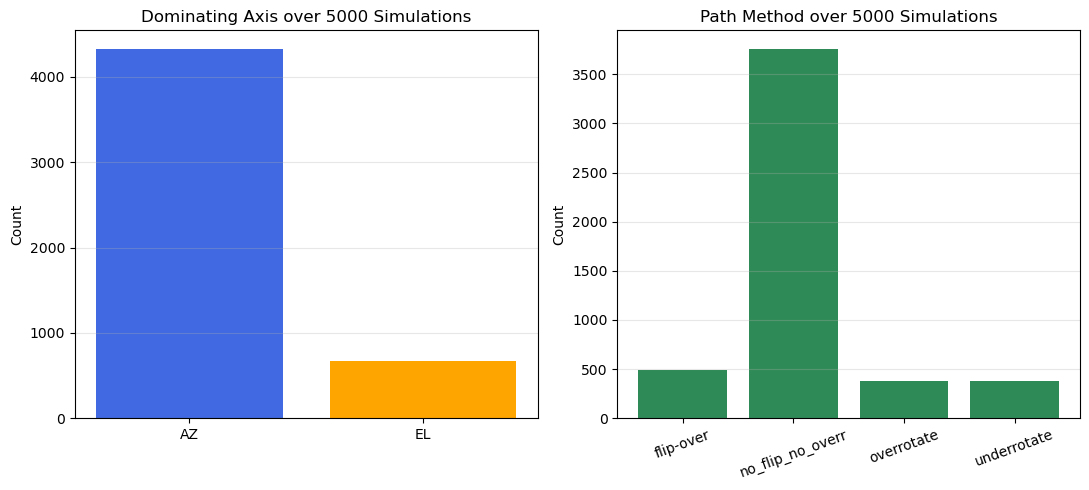

In [110]:
def dominating_axis_and_flip_rate(N=5000, steps=500, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    wps = random_waypoints(N)
    results = []

    for i in range(len(wps) - 1):
        start = wps[i]
        end = wps[i+1]

        alp_path = choose_path_logic(start, end, steps=steps)
        method = alp_path["name"]

        az1, el1 = start
        az2, el2 = end

        # Dominating axis
        az_diff = abs(wrap180(end[0] - start[0]))

        if method == "flip-over":
            el_diff = (90.0 - az1) + (90.0 - az2)
        else:
            el_diff = abs(end[1] - start[1])

        time_az = az_diff / AZ_SPEED
        time_el = el_diff / EL_SPEED
        dominating_axis = "AZ" if time_az > time_el else "EL"

        results.append({
            "From": start,
            "To": end,
            "Method": method,
            "DominatingAxis": dominating_axis,
            "Time (s)": alp_path["time"]
        })

    df_res = pd.DataFrame(results)




    # Stats
    method_counts = df_res["Method"].value_counts().sort_index()
    axis_counts = df_res["DominatingAxis"].value_counts().sort_index()
    flip_rate = (df_res["Method"] == "flip-over").mean()
    overr_rate = (df_res["Method"] == "overrotate").mean()
    underr_rate = (df_res["Method"] == "underrotate").mean()

    print(f"Flip-over rate:     {flip_rate  *    100:.3f} %")
    print(f"Overrotation rate:  {overr_rate  *   100:.3f} %")
    print(f"Underrotation rate: {underr_rate  *  100:.3f} %")
    print("\n\n\nMethod counts:\n")
    print(method_counts)
    print("\n\n\nDominating axis counts:\n")
    print(axis_counts)




    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    axs[0].bar(axis_counts.index, axis_counts.values, color=["royalblue", "orange"])
    axs[0].set_title(f"Dominating Axis over {N} Simulations")
    axs[0].set_ylabel("Count")
    axs[0].grid(True, axis="y", alpha=0.3)

    axs[1].bar(method_counts.index, method_counts.values, color="seagreen")
    axs[1].set_title(f"Path Method over {N} Simulations")
    axs[1].set_ylabel("Count")
    axs[1].tick_params(axis='x', rotation=20)
    axs[1].grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_res

df_sim = dominating_axis_and_flip_rate(N=5000, steps=200, seed=42)

In [111]:
def triple_method_time_heatmap(df, bins_az=30, bins_el=15):
    """
    Three heatmaps (one per method) showing average time by
    start elevation vs azimuth difference, same color scale,
    real-degree axes, flipped y-axis.
    """
    records = []
    for idx, row in df.iterrows():
        az1, el1 = row["From"]
        az2, el2 = row["To"]
        az_diff = abs(wrap180(az2 - az1))
        records.append({
            "Method": row["Method"],
            "AzDiff": az_diff,
            "ElStart": el1,
            "Time": row["Time (s)"]
        })

    df_geo = pd.DataFrame(records)

    # Real-degree bins
    az_bins = np.linspace(0, 180, bins_az + 1)
    el_bins = np.linspace(ELEVATION_MIN, 90, bins_el + 1)
    df_geo["AzBin"] = pd.cut(df_geo["AzDiff"], bins=az_bins, labels=False)
    df_geo["ElBin"] = pd.cut(df_geo["ElStart"], bins=el_bins, labels=False)

    # Shared color scale
    vmin = df_geo["Time"].min()
    vmax = df_geo["Time"].max()

    # Bin centers for labels
    az_centers = 0.5 * (az_bins[:-1] + az_bins[1:])
    el_centers = 0.5 * (el_bins[:-1] + el_bins[1:])

    methods = df_geo["Method"].unique()
    fig, axes = plt.subplots(1, len(methods), figsize=(6 * len(methods), 5), sharey=True)

    for ax, method in zip(axes, methods):
        df_m = df_geo[df_geo["Method"] == method]
        heat_data = df_m.groupby(["ElBin", "AzBin"])["Time"].mean().unstack()

        sns.heatmap(
            heat_data,
            cmap="YlGnBu",
            cbar_kws={"label": "Avg Time (s)"},
            ax=ax,
            vmin=vmin, vmax=vmax
        )

        # Degree labels
        ax.set_xticks(np.arange(len(az_centers)) + 0.5)
        ax.set_xticklabels([f"{c:.0f}" for c in az_centers])
        ax.set_yticks(np.arange(len(el_centers)) + 0.5)
        ax.set_yticklabels([f"{c:.0f}" for c in el_centers])

        ax.set_title(f"{method}")
        ax.set_xlabel("Azimuth Difference (°)")
        ax.set_ylabel("Start Elevation (°)")
        ax.invert_yaxis()

    plt.suptitle("Average Time per Method by Start Elevation vs Azimuth Diff", y=1.05)
    plt.tight_layout()
    plt.show()

    return df_geo


In [ ]:
def fastest_method_heatmap(df, bins_az=30, bins_el=15):
    """
    Categorical heatmap showing fastest method in each bin,
    real-degree axes, flipped y-axis.
    """
    records = []
    for idx, row in df.iterrows():
        az1, el1 = row["From"]
        az2, el2 = row["To"]
        az_diff = abs(wrap180(az2 - az1))
        records.append({
            "Method": row["Method"],
            "AzDiff": az_diff,
            "ElStart": el1,
            "Time": row["Time (s)"]
        })

    df_geo = pd.DataFrame(records)

    # Real-degree bins
    az_bins = np.linspace(0, 180, bins_az + 1)
    el_bins = np.linspace(ELEVATION_MIN, 90, bins_el + 1)
    df_geo["AzBin"] = pd.cut(df_geo["AzDiff"], bins=az_bins, labels=False)
    df_geo["ElBin"] = pd.cut(df_geo["ElStart"], bins=el_bins, labels=False)

    # Find fastest method per bin
    fastest_per_bin = (
        df_geo.groupby(["ElBin", "AzBin", "Method"])["Time"]
        .mean()
        .reset_index()
        .sort_values("Time")
        .drop_duplicates(subset=["ElBin", "AzBin"], keep="first")
    )

    heat_matrix = fastest_per_bin.pivot(index="ElBin", columns="AzBin", values="Method")

    # Map methods to ints
    methods = df_geo["Method"].unique()
    method_to_int = {m: i for i, m in enumerate(methods)}
    int_matrix = heat_matrix.replace(method_to_int)

    # Bin centers for labels
    az_centers = 0.5 * (az_bins[:-1] + az_bins[1:])
    el_centers = 0.5 * (el_bins[:-1] + el_bins[1:])

    # Plot
    fig, ax = plt.subplots(figsize=(11, 6))
    cmap = sns.color_palette("flare", n_colors=len(methods))
    sns.heatmap(
        int_matrix,
        cmap="flare",
        ax=ax
    )

    # Degree labels
    ax.set_xticks(np.arange(len(az_centers)) + 0.5)
    ax.set_xticklabels([f"{c:.0f}" for c in az_centers])
    ax.set_yticks(np.arange(len(el_centers)) + 0.5)
    ax.set_yticklabels([f"{c:.0f}" for c in el_centers])

    ax.set_xlabel("Azimuth Difference (°)")
    ax.set_ylabel("Start Elevation (°)")
    ax.invert_yaxis()

    # Legend
    from matplotlib.patches import Patch
    legend_patches = [Patch(color=cmap[i], label=m) for m, i in method_to_int.items()]
    ax.legend(
        handles=legend_patches,
        title="Fastest Method",
        bbox_to_anchor=(1.15, 1),
        loc="upper left"
    )

    plt.title("Fastest Method by Start Elevation vs Azimuth Diff")
    plt.tight_layout()
    plt.show()

    return heat_matrix

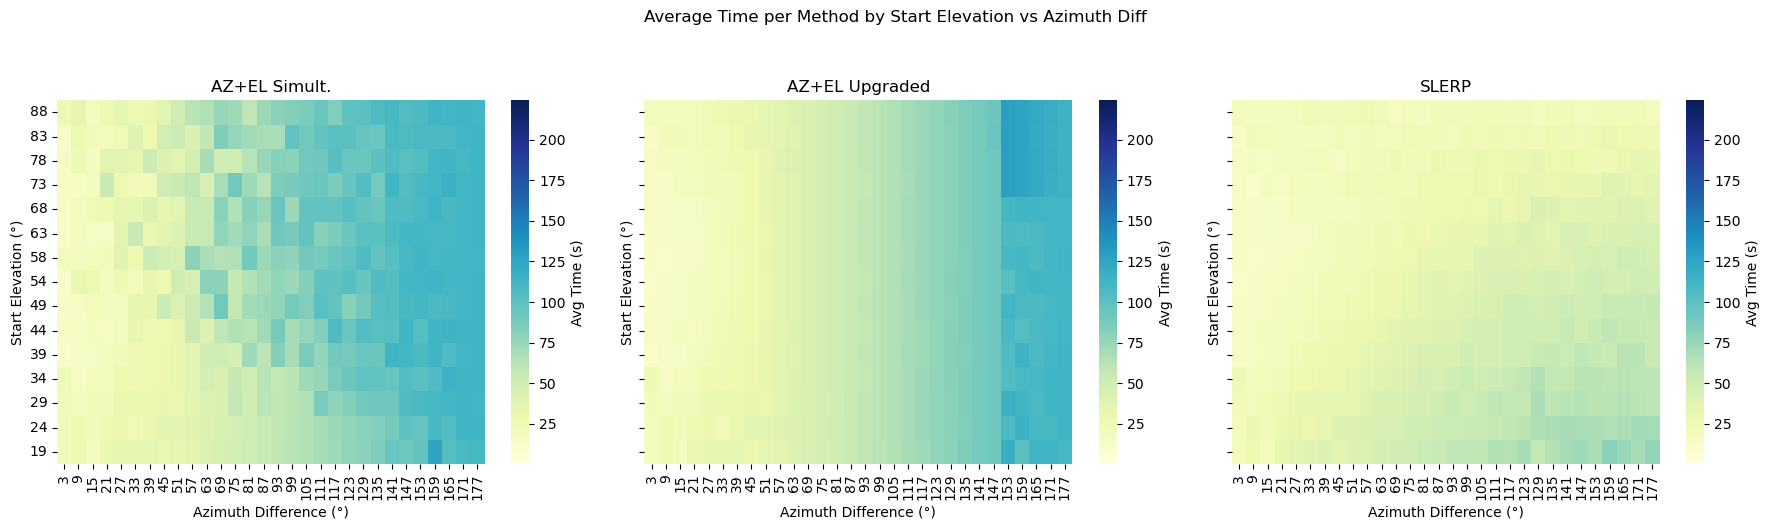

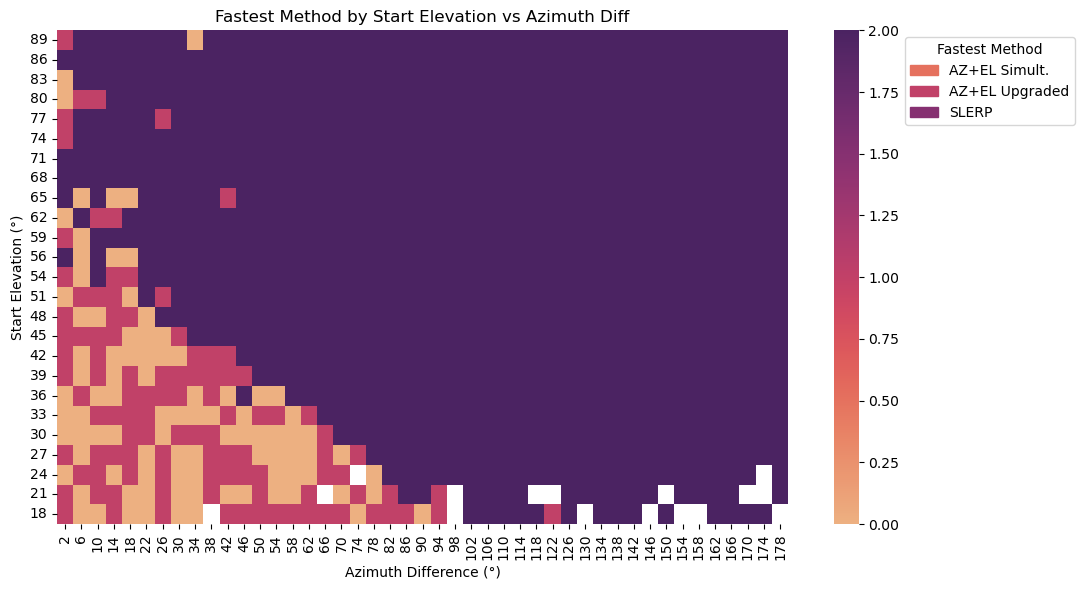

In [113]:
N = 10000
wps = random_waypoints(N)

df_rand = compare_method(wps, steps=500)

triple_method_time_heatmap(df_rand, bins_az=30, bins_el=15)
fastest_method_heatmap(df_rand, bins_az=45, bins_el=25)
pass

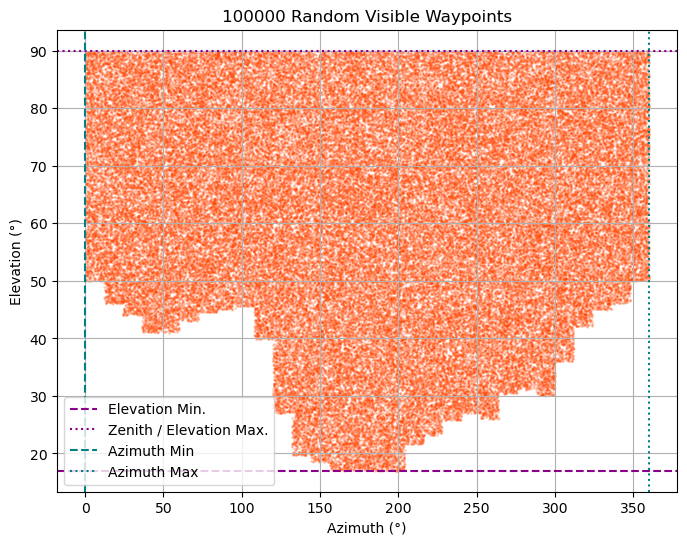

In [114]:
wpts = random_waypoints(100000)
az, el = zip(*wpts)

plt.figure(figsize=(8, 6))
plt.scatter(az, el, s=1, alpha=0.2, color="orangered")
plt.title(f"{len(wpts)} Random Visible Waypoints")
plt.xlabel("Azimuth (°)")
plt.ylabel("Elevation (°)")
plt.axhline(y=ELEVATION_MIN, color="darkmagenta", linestyle="--", label="Elevation Min.")
plt.axhline(y=90, color="darkmagenta", linestyle="dotted", label="Zenith / Elevation Max.")
plt.axvline(x=0, color="teal", linestyle="--", label="Azimuth Min")
plt.axvline(x=360, color="teal", linestyle="dotted", label="Azimuth Max")
plt.legend()
plt.grid(True)
plt.show()

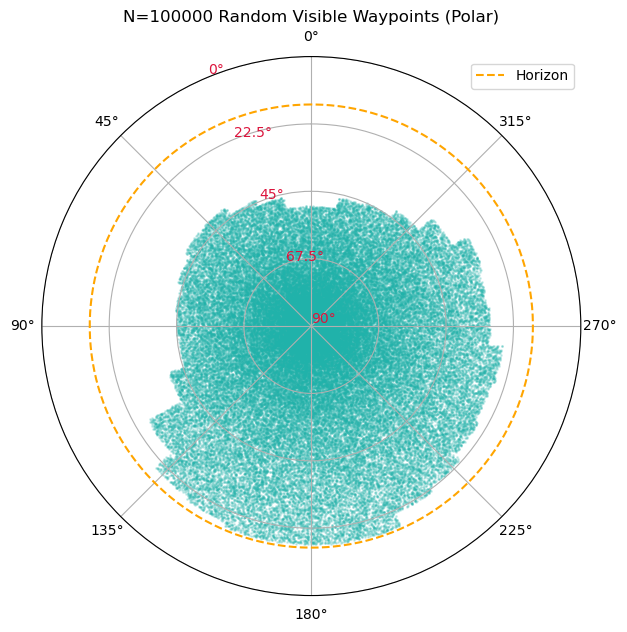

In [115]:
theta, r = zip(*[azel_to_polar(az, el) for az, el in wpts])

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.scatter(theta, r, s=1, alpha=0.2, color="lightseagreen")
theta_circle = np.linspace(0, 2*np.pi, 500)
r_circle = np.full_like(theta_circle, 90-16)
ax.plot(theta_circle, r_circle, color="orange", linestyle="--", label="Horizon")

ax.set_title(f"N={len(wpts)} Random Visible Waypoints (Polar)")
ax.set_ylim(0, 90)
ax.set_yticks([0, 22.5, 45, 67.5, 90])
ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0°"])
for label in ax.get_yticklabels():
    label.set_color("crimson")
ax.set_theta_zero_location("N")
ax.grid(True)
ax.legend()
plt.show()

In [116]:
# Modified choose_path function
def alp_only_overr_underr(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500
                         ) -> dict:
    az1, el1 = start
    az2, el2 = end

    # Determine path baseline values
    az_diff_signed = delta_shortest(az1, az2)    

    if (az1 + az_diff_signed > 360.0) and (az1 + az_diff_signed <= 540.0):
        return overrotate(start, end, steps=steps)

    if (az1 + az_diff_signed < 0.0) and (az1 + az_diff_signed >= -180.0):
        return underrotate(start, end, steps=steps)

    return normal_path(start, end, steps=steps)

# Modified choose_path function
def alp_only_flip(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    az1, el1 = start
    az2, el2 = end

    # Determine path baseline values
    az_diff_signed = delta_shortest(az1, az2)    

    # Decide if flip-over is useful
    near_zenith = (el1 >= el_flip_thresh) or (el2 >= el_flip_thresh)
    big_az = abs(az_diff_signed) >= az_flip_thresh


    if near_zenith and big_az:
        return flip_over(start, end, steps)

    return normal_path(start, end, steps=steps)

In [117]:
def benchmark(wps: List, method_func, method_name: str, steps=500):
    results = []

    for i in range(len(wps) - 1):
        start, end = wps[i], wps[i+1]
        
        normal = simultaneous_az_el_path(start, end, steps=steps)
        t_normal = slerp_path_time(normal)

        method = method_func(start, end, steps=steps)
        t_method = method["time"]

        gain = t_normal - t_method if t_method != t_normal else 0.0

        results.append({
            "From": start, "To": end,
            "Normal": t_normal,
            method_name: t_method,
            "Gain": gain,
        })

    return pd.DataFrame(results)

def alp_upgraded_wrapper(start, end, steps=500):
    return choose_path_logic(start, end, steps=steps)

def slerp_wrapper(start, end, steps=500):
    path = slerp_path(*start, *end, steps=steps)
    return {"time": slerp_direct_time(start, end), "path": path, "name": "SLERP"}

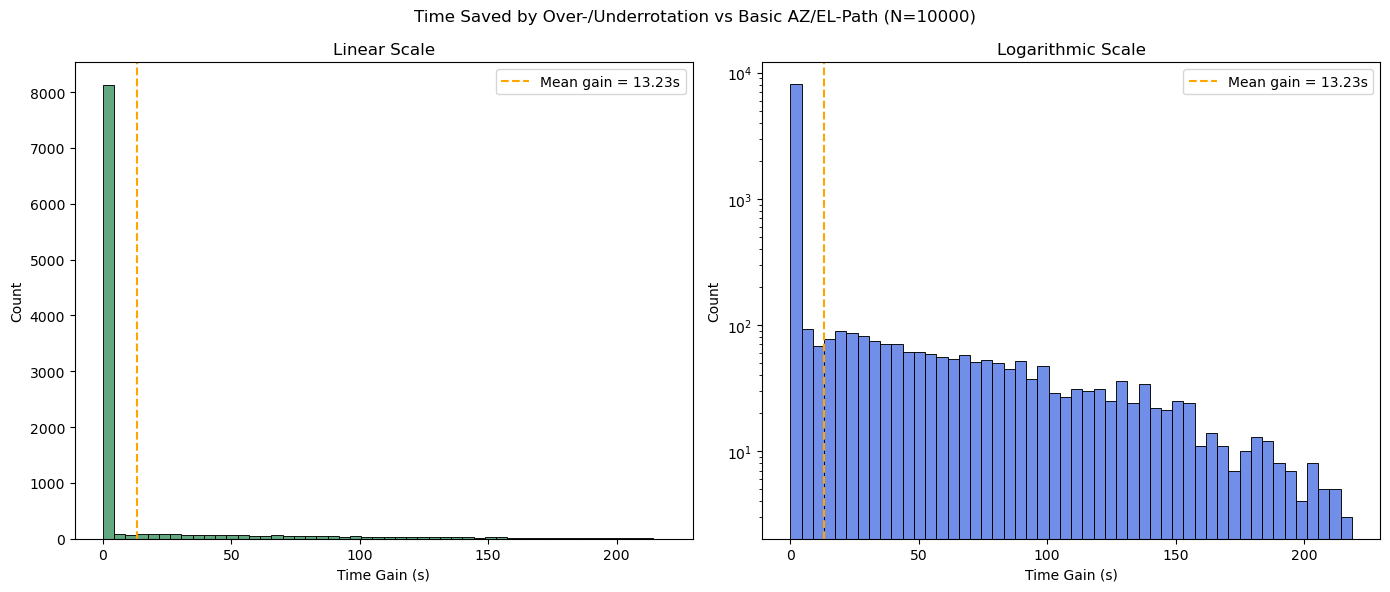

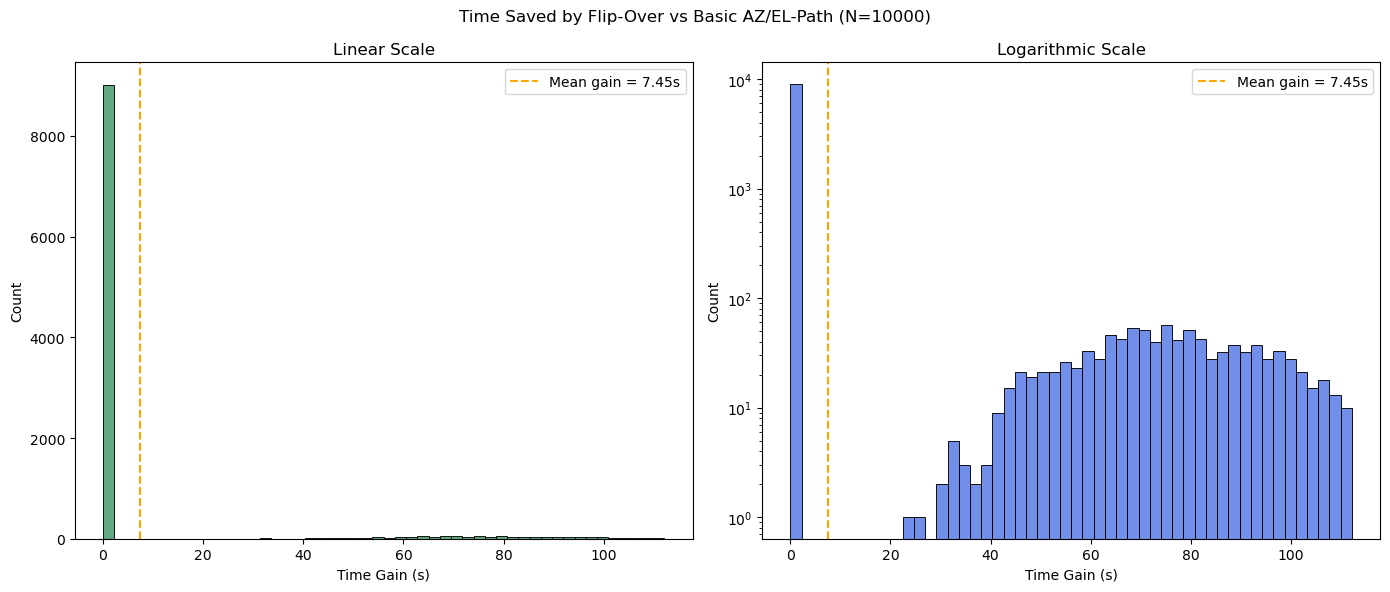

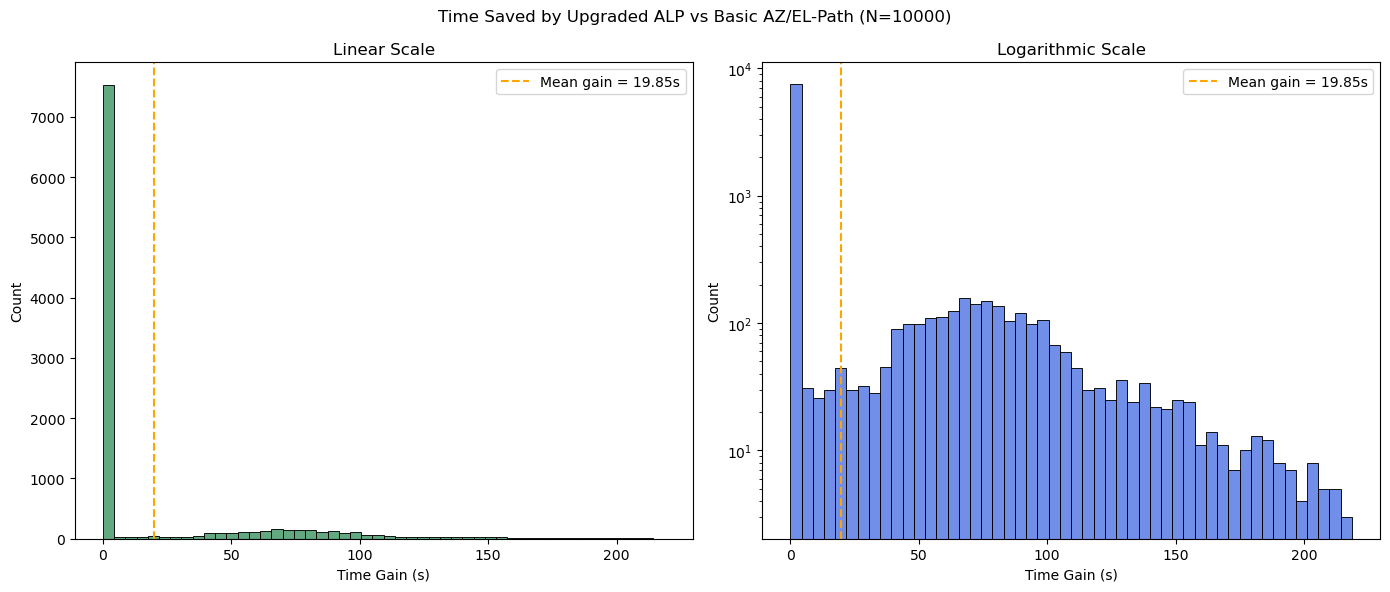

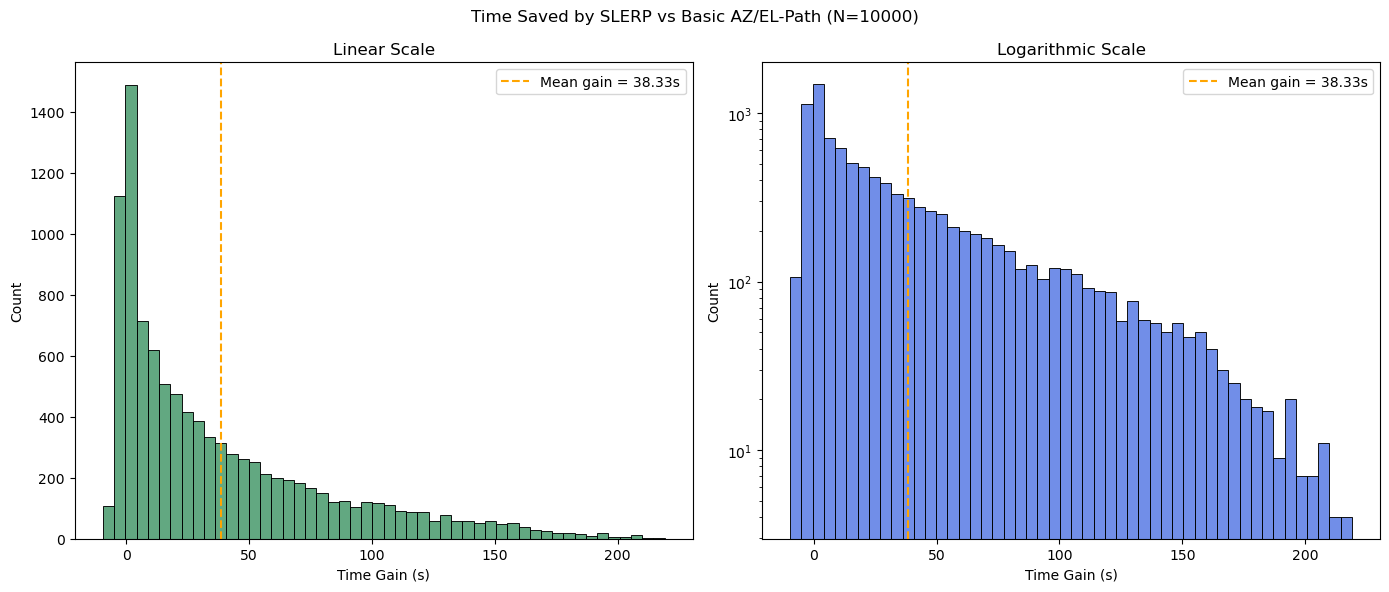

In [118]:
steps = 500
N = 10000
wps_visible = random_waypoints(N)

df_over_under   = benchmark(wps_visible, alp_only_overr_underr, "Over/Under", steps=steps)
df_flip         = benchmark(wps_visible, alp_only_flip, "Flip-Over", steps=steps)
df_upgr         = benchmark(wps_visible, alp_upgraded_wrapper, "Upgraded", steps=steps)
df_slerp        = benchmark(wps_visible, slerp_wrapper, "SLERP", steps=500)




# HISTOGRAM
def plot_gain_histograms(df, method_name, N):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    # Linear scale
    sns.histplot(df["Gain"], bins=50, kde=False, color="seagreen", ax=axs[0])
    axs[0].axvline(df["Gain"].mean(), color="orange", linestyle="--",
                label=f"Mean gain = {df['Gain'].mean():.2f}s")
    axs[0].set_title("Linear Scale")
    axs[0].set_xlabel("Time Gain (s)")
    axs[0].legend()

    # Logarithmic scale
    sns.histplot(df["Gain"], bins=50, kde=False, color="royalblue", ax=axs[1])
    axs[1].axvline(df["Gain"].mean(), color="orange", linestyle="--",
                label=f"Mean gain = {df['Gain'].mean():.2f}s")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Time Gain (s)")
    axs[1].set_title("Logarithmic Scale")
    axs[1].legend()

    plt.suptitle(f"Time Saved by {method_name} vs Basic AZ/EL-Path (N={N})")
    plt.tight_layout()

    plt.show()

plot_gain_histograms(df_over_under, "Over-/Underrotation", N)
plot_gain_histograms(df_flip, "Flip-Over", N)
plot_gain_histograms(df_upgr, "Upgraded ALP", N)
plot_gain_histograms(df_slerp, "SLERP", N)